In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
# import user_functions as uf 
# uf.korean()

# default_path = "../lab10/raw_data/"
# app_train = pd.read_csv(default_path+"application_train.csv")

data = pd.read_csv('./train_datasets.csv')

In [75]:
y_target = data[['TARGET']]
X_features = data.drop(columns=['Unnamed: 0','SK_ID_CURR','TARGET'])

In [76]:
pd.set_option('display.max_columns',60)
pd.set_option("max_rows", 60) 

In [77]:
X_features.info(60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303844 entries, 0 to 303843
Data columns (total 142 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    NAME_CONTRACT_TYPE                        int64  
 1    FLAG_OWN_CAR                              int64  
 2    FLAG_OWN_REALTY                           int64  
 3    CNT_CHILDREN                              int64  
 4    AMT_INCOME_TOTAL                          float64
 5    AMT_CREDIT                                float64
 6    AMT_ANNUITY                               float64
 7    AMT_GOODS_PRICE                           float64
 8    NAME_EDUCATION_TYPE                       int64  
 9    REGION_POPULATION_RELATIVE                float64
 10   DAYS_BIRTH                                int64  
 11   DAYS_EMPLOYED                             int64  
 12   DAYS_REGISTRATION                         float64
 13   DAYS_ID_PUBLISH                           

In [ ]:
21   승인/거부(prev_app)                           float64
 22   (추정)이자율                                   float64
 23   연체일                                       float64
 24   연체횟수                                      float64
 25   승인액/요청액                                   float64
 26   과거_상환액/총액                                 float64
 27   연체기간(pos_cash)                            float64
 28   소액연체비중(pos_cash)                          float64

In [78]:
X_features.rename(columns = {"승인/거부(prev_app)": "Approve_reject_prev_app", "(추정)이자율":"estimated_interest_rate",
                             "연체일": "overdue_date",
                            "연체횟수":"number_of_overdue", "승인액/요청액":"Approval_amount_request_amount",
                            "과거_상환액/총액":"Past_Payment_Amount_Total", "연체기간(pos_cash)":"Overdue_period_pos_cash)",
                            "소액연체비중(pos_cash)":"Share_of_small_delinquency_pos_cash",
                            '거주지일치여부':'Residence_match', '주변인채무':'Neighbors_Debt', 'CB문의':'CB_inquiry',
                            '서류여부':'Whether_documents'}, inplace=True)


In [79]:
X_features.info(60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303844 entries, 0 to 303843
Data columns (total 142 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    NAME_CONTRACT_TYPE                        int64  
 1    FLAG_OWN_CAR                              int64  
 2    FLAG_OWN_REALTY                           int64  
 3    CNT_CHILDREN                              int64  
 4    AMT_INCOME_TOTAL                          float64
 5    AMT_CREDIT                                float64
 6    AMT_ANNUITY                               float64
 7    AMT_GOODS_PRICE                           float64
 8    NAME_EDUCATION_TYPE                       int64  
 9    REGION_POPULATION_RELATIVE                float64
 10   DAYS_BIRTH                                int64  
 11   DAYS_EMPLOYED                             int64  
 12   DAYS_REGISTRATION                         float64
 13   DAYS_ID_PUBLISH                           

In [80]:
import re
X_features = X_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [81]:
#-------------------------------------------------------------------------------------------------
# 모델과 하이퍼 파라미터값을 전달 받아서
# 최적화 작업의 결과를 표시하는 함수 작성
# 릿지와 라쏘 모델의 최적화 alpha 값 추출
from sklearn.model_selection import GridSearchCV
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    
    rmse = np.sqrt(-1*grid_model.best_score_)
    
    print('{0} 5 CV 시 최적 평균 RMSE 값 :{1}, 최적 alpha {2}'.format(model.__class__.__name__, 
                                                                np.round(rmse, 4),
                                                               grid_model.best_params_))
    
    return grid_model.best_estimator_
#-------------------------------------------------------------------------------------------------

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [82]:
# LigtGMB
from lightgbm import LGBMClassifier


In [83]:
# 학습/테스트 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_features , y_target, test_size=0.2, 
                                                       stratify=y_target, random_state=2021)
print(X_train.shape, X_test.shape)

(243075, 142) (60769, 142)


In [84]:
lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.275042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.271311
[3]	valid_0's binary_logloss: 0.268389
[4]	valid_0's binary_logloss: 0.266049
[5]	valid_0's binary_logloss: 0.263816
[6]	valid_0's binary_logloss: 0.26213
[7]	valid_0's binary_logloss: 0.260583
[8]	valid_0's binary_logloss: 0.2591
[9]	valid_0's binary_logloss: 0.25794
[10]	valid_0's binary_logloss: 0.256879
[11]	valid_0's binary_logloss: 0.256017
[12]	valid_0's binary_logloss: 0.255204
[13]	valid_0's binary_logloss: 0.254386
[14]	valid_0's binary_logloss: 0.253666
[15]	valid_0's binary_logloss: 0.253111
[16]	valid_0's binary_logloss: 0.252611
[17]	valid_0's binary_logloss: 0.252151
[18]	valid_0's binary_logloss: 0.251592
[19]	valid_0's binary_logloss: 0.251161
[20]	valid_0's binary_logloss: 0.250757
[21]	valid_0's binary_logloss: 0.250359
[22]	valid_0's binary_logloss: 0.249864
[23]	valid_0's binary_logloss: 0.249522
[24]	valid_0's binary_logloss: 

In [85]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[55764   112]
 [ 4748   145]]
정확도: 0.9200, 정밀도: 0.5642, 재현율: 0.0296,    F1: 0.0563, AUC:0.7651


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

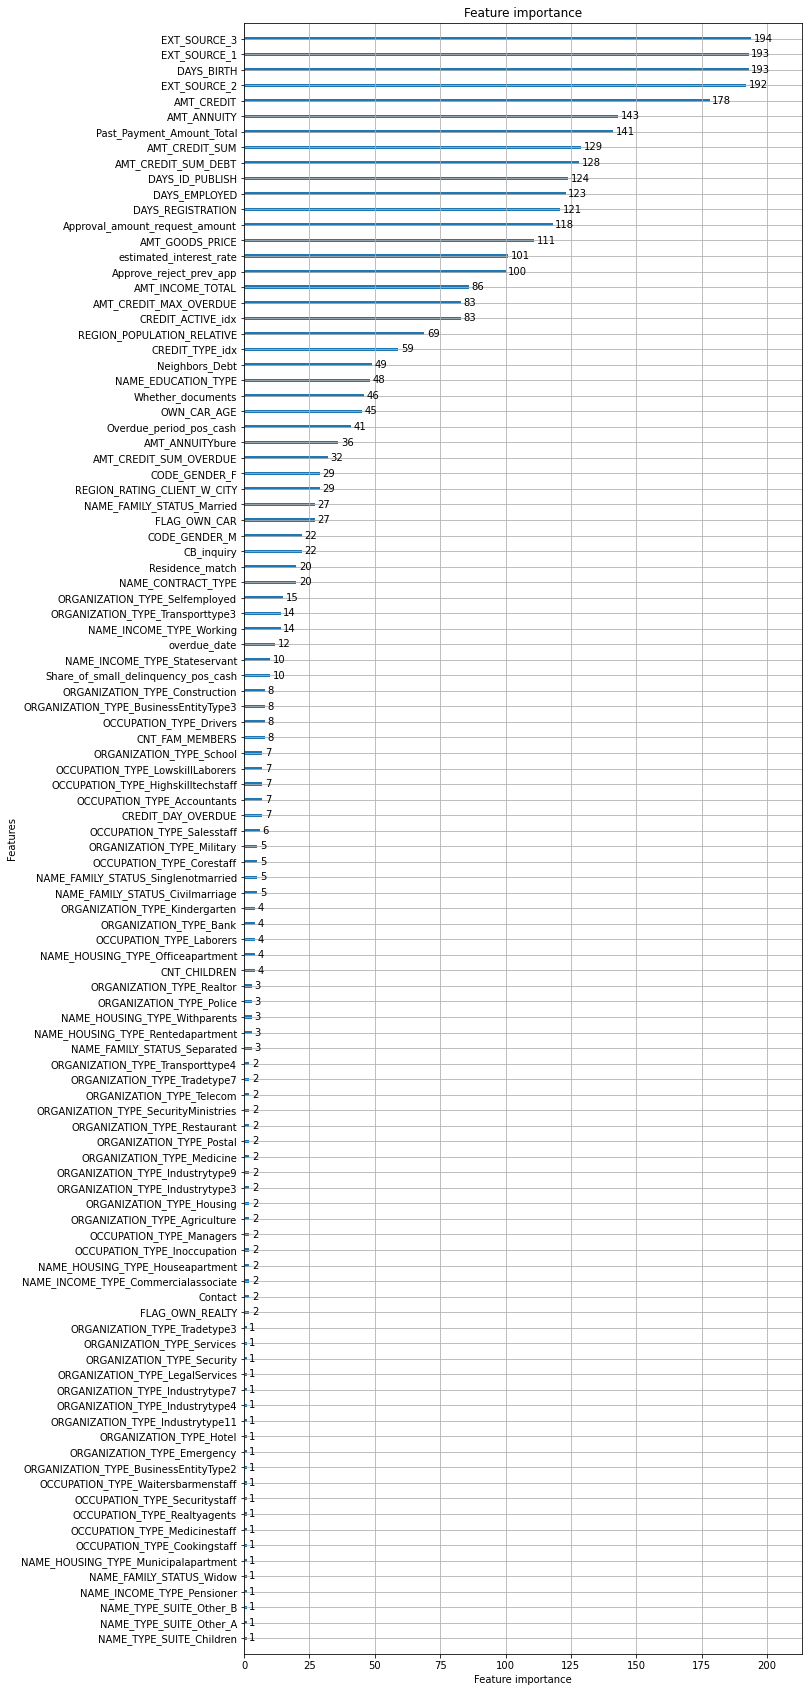

In [86]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(lgbm_wrapper, ax=ax)

In [88]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.705365	valid_0's binary_logloss: 0.275042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.713977	valid_0's binary_logloss: 0.271311
[3]	valid_0's auc: 0.717764	valid_0's binary_logloss: 0.268389
[4]	valid_0's auc: 0.719674	valid_0's binary_logloss: 0.266049
[5]	valid_0's auc: 0.72392	valid_0's binary_logloss: 0.263816
[6]	valid_0's auc: 0.727288	valid_0's binary_logloss: 0.26213
[7]	valid_0's auc: 0.729012	valid_0's binary_logloss: 0.260583
[8]	valid_0's auc: 0.731686	valid_0's binary_logloss: 0.2591
[9]	valid_0's auc: 0.733502	valid_0's binary_logloss: 0.25794
[10]	valid_0's auc: 0.735019	valid_0's binary_logloss: 0.256879
[11]	valid_0's auc: 0.736395	valid_0's binary_logloss: 0.256017
[12]	valid_0's auc: 0.737548	valid_0's binary_logloss: 0.255204
[13]	valid_0's auc: 0.739254	valid_0's binary_logloss: 0.254386
[14]	valid_0's auc: 0.740527	valid_0's binary_logloss: 0.253666
[15]	valid_0's auc: 0.741233	valid_0's binary_logloss: 0

In [89]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.705365	valid_0's binary_logloss: 0.275042
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.713977	valid_0's binary_logloss: 0.271311
[3]	valid_0's auc: 0.717764	valid_0's binary_logloss: 0.268389
[4]	valid_0's auc: 0.719674	valid_0's binary_logloss: 0.266049
[5]	valid_0's auc: 0.72392	valid_0's binary_logloss: 0.263816
[6]	valid_0's auc: 0.727288	valid_0's binary_logloss: 0.26213
[7]	valid_0's auc: 0.729012	valid_0's binary_logloss: 0.260583
[8]	valid_0's auc: 0.731686	valid_0's binary_logloss: 0.2591
[9]	valid_0's auc: 0.733502	valid_0's binary_logloss: 0.25794
[10]	valid_0's auc: 0.735019	valid_0's binary_logloss: 0.256879
[11]	valid_0's auc: 0.736395	valid_0's binary_logloss: 0.256017
[12]	valid_0's auc: 0.737548	valid_0's binary_logloss: 0.255204
[13]	valid_0's auc: 0.739254	valid_0's binary_logloss: 0.254386
[14]	valid_0's auc: 0.740527	valid_0's binary_logloss: 0.253666
[15]	valid_0's auc: 0.741233	valid_0's binary_logloss: 0

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 수행속도 향상을 위한다면 estimator 수치 조정
lgbm_clf = LGBMClassifier(n_estimators=1000)

params = {'num_leaves' :[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

# cv는 5로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=5)
gridcv.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc",
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 :', gridcvcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test[:,1], average='macro'))
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.706955	valid_0's binary_logloss: 0.274983	valid_1's auc: 0.704544	valid_1's binary_logloss: 0.275022
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.716327	valid_0's binary_logloss: 0.271069	valid_1's auc: 0.712629	valid_1's binary_logloss: 0.271288
[3]	valid_0's auc: 0.722678	valid_0's binary_logloss: 0.268067	valid_1's auc: 0.718944	valid_1's binary_logloss: 0.268361
[4]	valid_0's auc: 0.726641	valid_0's binary_logloss: 0.26546	valid_1's auc: 0.722767	valid_1's binary_logloss: 0.265853
[5]	valid_0's auc: 0.729701	valid_0's binary_logloss: 0.26335	valid_1's auc: 0.725813	valid_1's binary_logloss: 0.263806
[6]	valid_0's auc: 0.731333	valid_0's binary_logloss: 0.261491	valid_1's auc: 0.72735	valid_1's binary_logloss: 0.262085
[7]	valid_0's auc: 0.732982	valid_0's binary_logloss: 0.259942	valid_1's auc: 0.729119	valid_1's binary_logloss: 0.260591
[8]	valid_0's auc: 0.735523	valid_0's binary_logloss: 0.258414	valid_1's auc: 0.731241	

In [ ]:
#
lgbm_clf = LGBMClassifier(n_estimators=,num_leaves=, min_child_samples=, max_depth=)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=500, eval_metric="auc", eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_socre(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

In [ ]:
# nthread=4,
clf = LGBMClassifier(                
                n_estimators=4000,
                learning_rate=0.01,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )

In [ ]:
def train_apps_all_with_oof(apps_all_train, apps_all_test, nfolds=5):
from sklearn.model_selection import KFold

    """
    Predict credit risk using OOF(Out of Fold) method 
    Parameter : apps_all_train, apps_all_test, nfolds count
    """
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)  # feature dateset
    target_app = apps_all_train['TARGET']                           # target datasets

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits = nfolds, shuffle=True, random_state = 2020)
    
    #  Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr_app.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(apps_all_test.shape[0])
    
    # n_estimators를 4000까지 확대. 
    # 현재 데이터셋으로 하이터 파라미터를 튜닝하는것이 바람직.
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx , valid_idx) in enumerate(folds.split(ftr_app)):
        print("##### iteration ", fold_idx, 'starts')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr_app.iloc[train_idx, :]
        train_y = target_app.iloc[train_idx]
        valid_x = ftr_app.iloc[valid_idx, :]
        valid_y = target_app.iloc[valid_idx]

        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장 사용되지는 않음. 
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        # num_iteration  - stops at the time of early stopping
        # [0 - normal , 1 - overdue] : fetch the probability of overdue
        # Predecited probabily should be mean value 
        test_preds += clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis = 1),num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
    return clf, test_preds


In [ ]:
import datetime
 
print("Starting Time " , datetime.datetime.now())

clf, test_preds = train_apps_all_with_oof(apps_all_train, apps_all_test, nfolds=5)

print("End Time : ", datetime.datetime.now())

In [56]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)
best_lgmb = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 :0.2602, 최적 alpha {'n_estimators': 1000}


In [60]:
# 앞으로 피처 엔지니어링을 수행할 때마다
# 모델을 학습/예측/평가하는데 사용할 함수 작성

# 사이킷런의 Estimater객체, 학습/테스트 데이터 세트 입력 받아서
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgr_train=None, tgt_test=None):
    model.fit(ftr_train, tgr_train) # 학습
    pred = model.predict(ftr_test) # 예측(값)
    pred_proba = model.predict_proba(ftr_test)[:, 1] # 예측 확률
    get_clf_eval(tgt_test, pred, pred_proba)  # 실제 데이터, 예측값, 예측 확률

In [59]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[55764   112]
 [ 4748   145]]
정확도: 0.9200, 정밀도: 0.5642, 재현율: 0.0296,    F1: 0.0563, AUC:0.7651


In [61]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=64, n_jobs=-1, \
                         boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgr_train=y_train, tgt_test=y_test)

오차 행렬
[[55733   143]
 [ 4743   150]]
정확도: 0.9196, 정밀도: 0.5119, 재현율: 0.0307,    F1: 0.0578, AUC:0.7636


In [67]:
import lightgbm as lgbm
import sklearn
import sys

print("lightgbm",lgbm.__version__)

lightgbm 3.2.1


In [68]:
print("lightgbm",lgbm.__version__)
print('sklearn',sklearn.__version__)
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('python',sys.version)

lightgbm 3.2.1
sklearn 0.24.2
pandas 1.3.1
numpy 1.20.3
python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

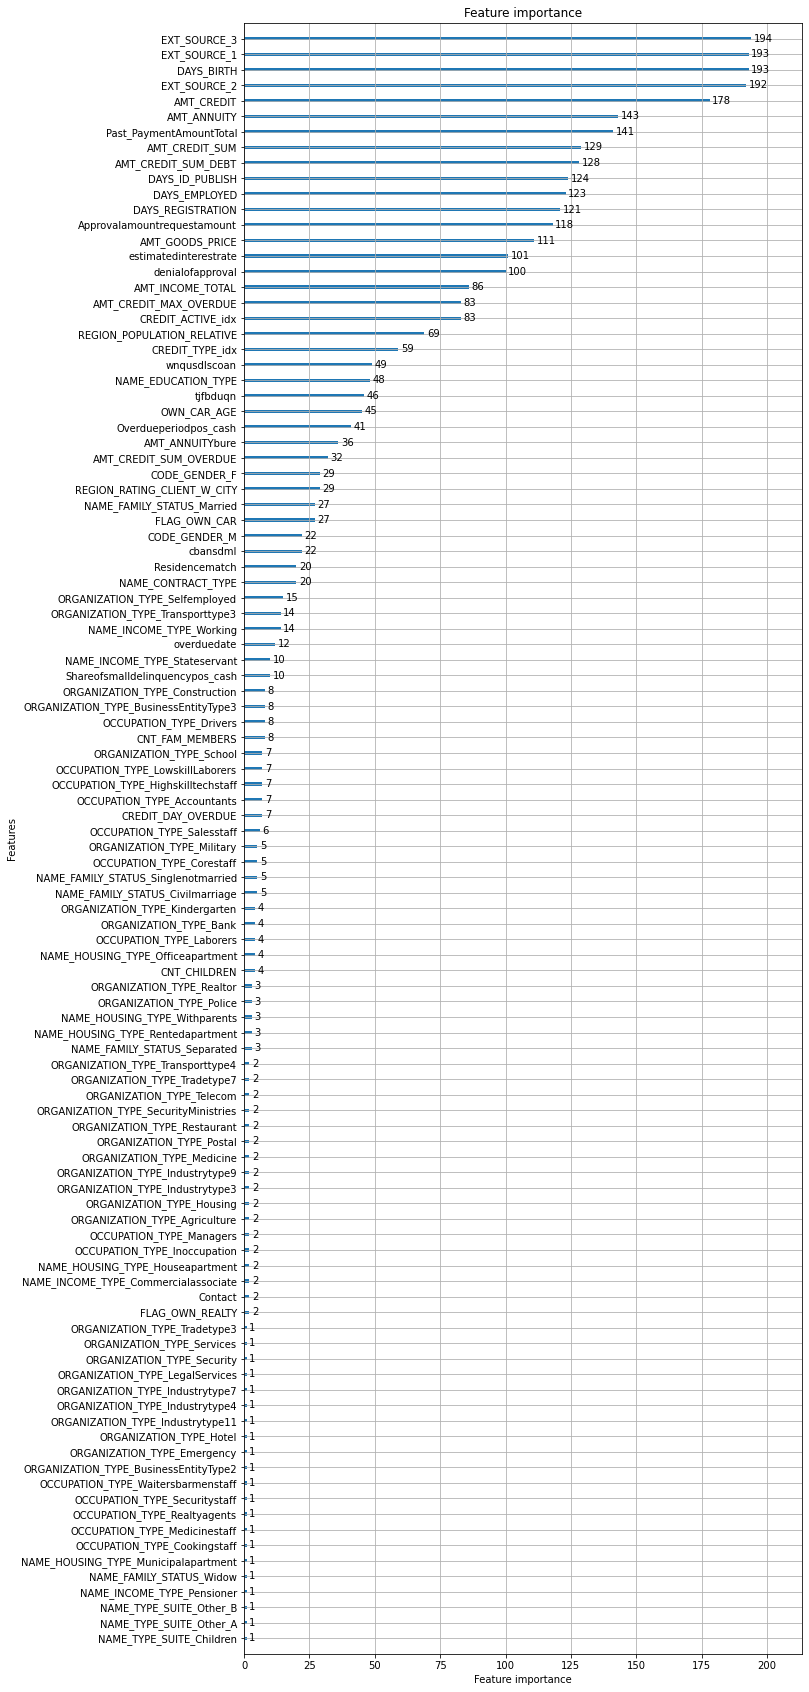

In [72]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(lgbm_wrapper, ax=ax)